In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, f1_score, recall_score,
                             precision_score, accuracy_score)
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/SumantaSethi/Bank-Customer-Churn-Prediction/main/Churn_Modelling_Clean.csv')

# Separate features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

# Encoding categorical variables

In [4]:
# Create a copy for encoding
X_encoded = X.copy()

# Label Encoding for Geography (ordinal relationship not assumed, but works for LR)
le_geo = LabelEncoder()
X_encoded['Geography'] = le_geo.fit_transform(X['Geography'])

# Label Encoding for Gender
le_gender = LabelEncoder()
X_encoded['Gender'] = le_gender.fit_transform(X['Gender'])

print("Encoding mappings:")
print(f"Geography: {dict(zip(le_geo.classes_, le_geo.transform(le_geo.classes_)))}")
print(f"Gender: {dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_)))}")


Encoding mappings:
Geography: {'France': np.int64(0), 'Germany': np.int64(1), 'Spain': np.int64(2)}
Gender: {'Female': np.int64(0), 'Male': np.int64(1)}


# TRAIN-TEST SPLIT

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
      X_encoded, y,
          test_size=0.2,
              random_state=42,
                  stratify=y  # Maintains class distribution
                  )

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"Training set churn rate: {y_train.mean()*100:.2f}%")
print(f"Test set churn rate: {y_test.mean()*100:.2f}%")

Training set size: 8000 samples
Test set size: 2000 samples
Training set churn rate: 20.38%
Test set churn rate: 20.35%


# CREATE PIPELINE WITH SCALING

In [8]:
pipeline = Pipeline([
      ('scaler', StandardScaler()),  # Standardize features
          ('classifier', LogisticRegression(random_state=42, max_iter=1000))
          ])

print("Pipeline created:")
print(pipeline)

Pipeline created:
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])


# HYPERPARAMETER TUNING WITH GRID SEARCH

In [10]:
# Define parameter grid
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l1', 'l2'],  # Regularization type
    'classifier__solver': ['liblinear', 'saga']  # Optimization algorithm
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='recall',  # Optimize for recall (catching churners)
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation recall score: {grid_search.best_score_:.4f}")

# Use the best model
best_model = grid_search.best_estimator_

Starting Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation recall score: 0.1742


# EVALUATE ON TEST SET

In [11]:
# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n📊 MODEL PERFORMANCE METRICS:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1 Score:  {f1:.4f}")
print(f"   ROC-AUC:   {roc_auc:.4f}")

# Classification report
print("\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred,
                          target_names=['Stayed', 'Churned']))


📊 MODEL PERFORMANCE METRICS:
   Accuracy:  0.8050
   Precision: 0.5859
   Recall:    0.1425
   F1 Score:  0.2292
   ROC-AUC:   0.7710

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Stayed       0.82      0.97      0.89      1593
     Churned       0.59      0.14      0.23       407

    accuracy                           0.81      2000
   macro avg       0.70      0.56      0.56      2000
weighted avg       0.77      0.81      0.75      2000



# CONFUSION MATRIX VISUALIZATION

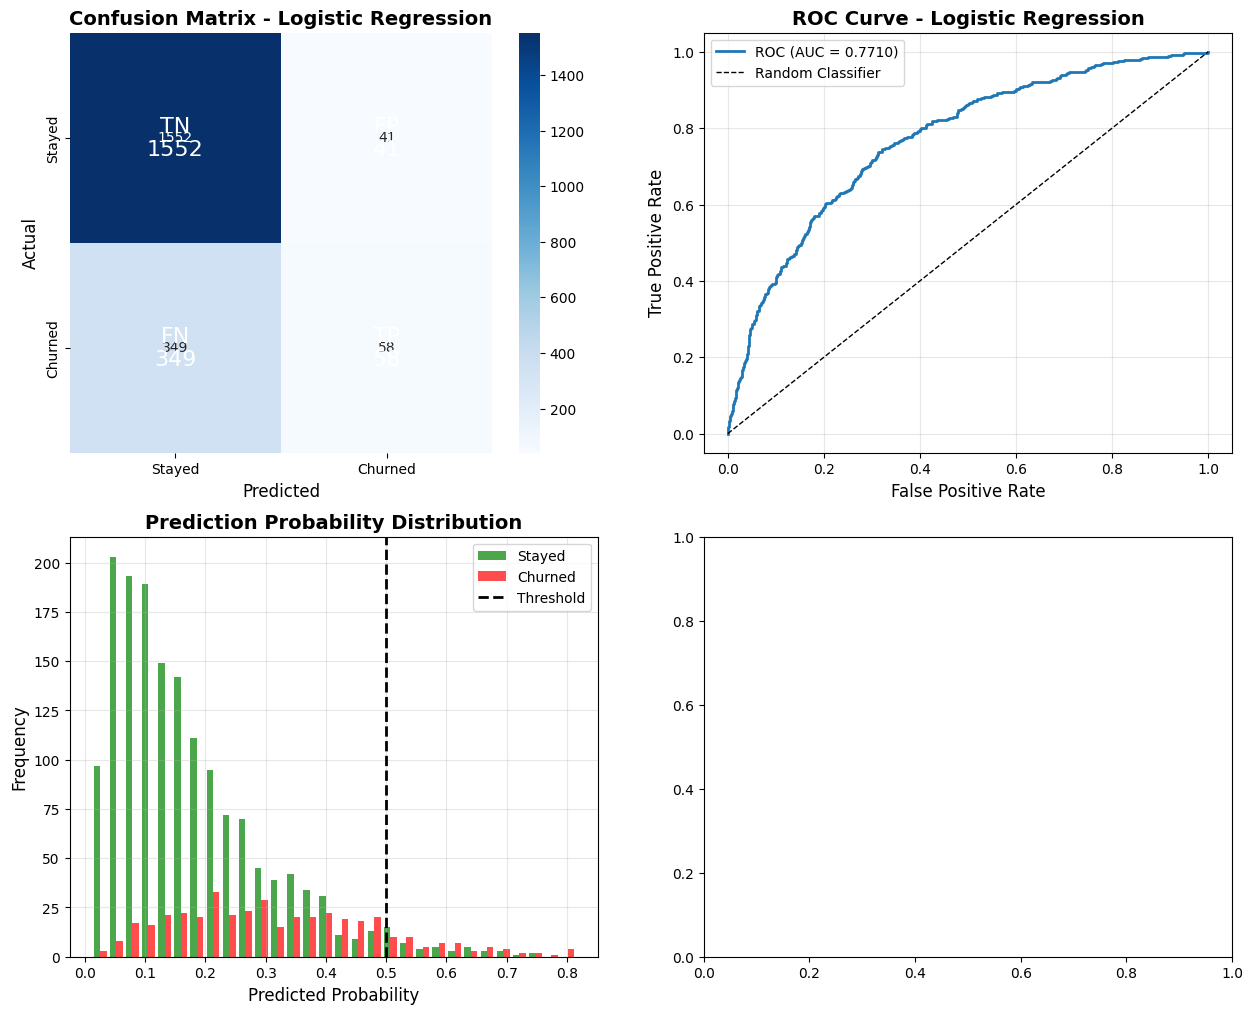

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Stayed', 'Churned'],
            yticklabels=['Stayed', 'Churned'])
axes[0, 0].set_title('Confusion Matrix - Logistic Regression',
                     fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Actual', fontsize=12)
axes[0, 0].set_xlabel('Predicted', fontsize=12)

# Add text annotations
tn, fp, fn, tp = cm.ravel()
axes[0, 0].text(0.5, 0.5, f'TN\n{tn}', ha='center', va='center', fontsize=16, color='white')
axes[0, 0].text(1.5, 0.5, f'FP\n{fp}', ha='center', va='center', fontsize=16, color='white')
axes[0, 0].text(0.5, 1.5, f'FN\n{fn}', ha='center', va='center', fontsize=16, color='white')
axes[0, 0].text(1.5, 1.5, f'TP\n{tp}', ha='center', va='center', fontsize=16, color='white')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.4f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 1].set_title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Prediction Distribution
axes[1, 0].hist([y_pred_proba[y_test==0], y_pred_proba[y_test==1]],
                bins=30, label=['Stayed', 'Churned'],
                color=['green', 'red'], alpha=0.7)
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1, 0].set_xlabel('Predicted Probability', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Feature Coefficients